In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

# 🩸 Introduction

The landscape of organized crime in Mexico is dominated by powerful and often violent cartels that have evolved over decades. These criminal organizations, primarily involved in drug trafficking, have created a complex web of alliances and rivalries that significantly impact the country's security and stability. Understanding these relationships is crucial for grasping the broader context of violence and power dynamics within the region.

Mexican cartels are notorious for their involvement in a range of criminal activities, including drug trafficking, extortion, kidnapping, human trafficking, and money laundering. The most prominent cartels, such as the Sinaloa Cartel, the Jalisco New Generation Cartel (CJNG), and the Gulf Cartel, have established extensive networks that operate both domestically and internationally. These organizations are not only involved in the production and distribution of drugs like cocaine, heroin, methamphetamine, and marijuana but also engage in brutal tactics to maintain their dominance and control over lucrative trafficking routes.

The relationships between these cartels are marked by a combination of strategic alliances and fierce rivalries. Alliances are often formed to consolidate power, expand territorial control, and increase operational efficiency. For example, smaller cartels may align with more powerful ones to gain protection and access to trafficking routes. On the other hand, rivalries between cartels are driven by competition for territory, resources, and influence, leading to violent clashes and sustained conflicts.

In this notebook, we will visualize the intricate relationships between Mexican cartels. By employing network analysis and interactive visualizations, we aim to shed light on the complex and often hidden connections that shape the operations and strategies of these criminal organizations. Through this exploration, we seek to provide a deeper understanding of the factors driving the violence and instability associated with Mexican cartels.

In [2]:
trends = pd.read_csv('/kaggle/input/mexican-cartels-network/Trends2012_2021.csv')
aliances =  pd.read_csv('/kaggle/input/mexican-cartels-network/BACRIM2020_Alliances.csv')
rivals =  pd.read_csv('/kaggle/input/mexican-cartels-network/BACRIM2020_Rivals.csv')

# ⚙️ Preprocessing

Before we start there is one small but important task to do. Look at the following extract from the dataframe. 

In [3]:
aliances.loc[aliances['RGroup'] == 'Cártel del Golfo']

,Edge,Node,Group,RNode,RGroup,weight
11,R10107,N10116,Los Pelones,N10017,Cártel del Golfo,4
56,R10060,N10061,Grupo Sombra,N10017,Cártel del Golfo,2
121,R10114,N10127,Los Talibanes,N10017,Cártel del Golfo,1


In [4]:
aliances.loc[aliances['Group'] == 'Cártel del Golfo']

,Edge,Node,Group,RNode,RGroup,weight
7,R10020,N10017,Cártel del Golfo,N10116,Los Pelones,4
36,R10019,N10017,Cártel del Golfo,N10061,Grupo Sombra,2


As you see we have redundant information in the dataset. The alliance between `Cártel del Golfo` and `Los Pelones` occurs two times. 

Although it does not cause any problems when generating the network, it does cause problems when aggregating values for the hover in the graphic. 

I create a sorted combination of the two columns `Node` and `RNode` and discard one of the duplicate entries. 

In [5]:
aliances['unique_pair'] = aliances.apply(lambda row: tuple(sorted([row['Node'], row['RNode']])), axis=1)
aliances = aliances.drop_duplicates(subset=['unique_pair'], keep='first')
aliances = aliances.drop(columns=['unique_pair'])

Let´s check again. 

In [6]:
aliances.loc[aliances['RGroup'] == 'Cártel del Golfo']

,Edge,Node,Group,RNode,RGroup,weight
121,R10114,N10127,Los Talibanes,N10017,Cártel del Golfo,1


In [7]:
aliances.loc[aliances['Group'] == 'Cártel del Golfo']

,Edge,Node,Group,RNode,RGroup,weight
7,R10020,N10017,Cártel del Golfo,N10116,Los Pelones,4
36,R10019,N10017,Cártel del Golfo,N10061,Grupo Sombra,2


Also apply to the rivals dataframe. 

In [8]:
rivals['unique_pair'] = rivals.apply(lambda row: tuple(sorted([row['Node'], row['RNode']])), axis=1)
rivals = rivals.drop_duplicates(subset=['unique_pair'], keep='first')
rivals = rivals.drop(columns=['unique_pair'])

Finally we create a new dataframe which holds aggregated relationships for aliances and rivals. The dataframe is not interesting for the network graph, I need it for separate bar charts. 

In [9]:
alliance_group_df = aliances[['Group', 'RGroup', 'weight']]
alliance_rgroup_df = aliances[['RGroup', 'Group', 'weight']]
alliance_rgroup_df.columns = ['Group', 'RGroup', 'weight']
combined_alliance_df = pd.concat([alliance_group_df, alliance_rgroup_df])

alliance_grouped_df = combined_alliance_df.groupby('Group').agg(
    alliances=('RGroup', 'count'),
    total_alliance_weight=('weight', 'sum')
).reset_index()

rival_group_df = rivals[['Group', 'RGroup', 'weight']]
rival_rgroup_df = rivals[['RGroup', 'Group', 'weight']]
rival_rgroup_df.columns = ['Group', 'RGroup', 'weight']
combined_rival_df = pd.concat([rival_group_df, rival_rgroup_df])

rival_grouped_df = combined_rival_df.groupby('Group').agg(
    rivals=('RGroup', 'count'),
    total_rival_weight=('weight', 'sum')
).reset_index()

relationship_count_df = alliance_grouped_df.merge(rival_grouped_df, on='Group', how='outer').fillna(0)
relationship_count_df[['alliances', 'total_alliance_weight', 'rivals', 'total_rival_weight']] = relationship_count_df[['alliances', 'total_alliance_weight', 'rivals', 'total_rival_weight']].astype(int)

In [10]:
relationship_count_df

,Group,alliances,total_alliance_weight,rivals,total_rival_weight
0,ACME,3,5,0,0
1,CJNG Comando la Mancha,1,2,1,1
2,Caballeros Templarios,1,4,3,8
3,Cártel Jalisco Nueva Generación (CJNG),28,55,27,77
4,Cártel Los Epitacio,1,1,0,0
...,...,...,...,...,...
109,Sindicato Libertad,1,2,0,0
110,Tercera Acción Destructiva (3AD),1,1,0,0
111,Tropa del Infierno,1,3,3,3
112,U o la UVA,1,3,0,0


# 📈 Violence in Numbers

Mexican cartels lose many members due to conflict with other cartels or arrests. Yet, despite their losses cartels managed to increase violance for years. In 2021 around 177k persons where involved in either violance or arrests. According to the Fortune Global 500 ranking, which rankes the world´s largest companies  by annual revenue Pemex, América Móvil and Fomento Económico Mexicano are listed which are all Mexican companies. Pemex has approx. 120,000 employees, América Móvil employs 176,000 people. 

Although the trend data set only goes up to 2021, a significant increase in cartel memberships is very likely. It is no exaggeration to say that the Mexican cartels are among the top employers in Mexico. 

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=trends['YEAR'],
    y=trends['homicide'],
    name='Homicide',
    marker_color='steelblue'
))
fig.add_trace(go.Bar(
    x=trends['YEAR'],
    y=trends['missings'],
    name='Missings',
    marker_color='mediumseagreen'
))
fig.add_trace(go.Bar(
    x=trends['YEAR'],
    y=trends['arrests'],
    name='Arrests',
    marker_color='darkorange'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Crime Trend between 2012 and 2022')
fig.show();

# 📝 (un)important theory

Network graphs are powerful tools used to represent and analyze complex relationships and structures in various domains. At their core, network graphs consist of nodes (or vertices) and edges (or links) that connect pairs of nodes. This structure is used to model and visualize a wide range of systems, from social networks to biological systems and, in this case, the relationships between criminal organizations.

**Nodes** represents entities or actors in the network. In our context, nodes would represend different cartels. 

**Edges** represent the relationship or interactions between nodes. In our context, edges represents the number of states in which two states are allied or fighting in 2020. 

We can distinguish between two types of networks:

**Undirected Networks**: Edges have no direction, indicating a mutual relationship. For example, an alliance between two cartels. 

**Direct Networks**: Edges have a direction, indicating a one-way relationship. This can be useful for showing influence or dominance of one cartel over another. (*This is not part of this work*)

There is another theory on the subject of network analysis. For example, communities and centralities play an important role in the graphs. However, this will not be discussed further in this notebook. 

# 🕸️ Cartel Relationship


In [12]:
def create_node_trace(G, pos, data, text, color):
    node_x = []
    node_y = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        total_relationships = len(list(G.neighbors(node)))
        total_states = data[(data['Node'] == node) | (data['RNode'] == node)]['weight'].sum()
        group = data[data['Node'] == node]['Group'].values[0] if node in data['Node'].values else data[data['RNode'] == node]['RGroup'].values[0]
        node_info = f"Node: {node}<br>Group: {group}<br>Total {text}: {total_relationships}<br>Total States: {total_states}"
        node_text.append(node_info)

    node_adjacencies = [len(list(G.neighbors(node))) for node in G.nodes()]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        text=node_text,
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale=color,
            color=node_adjacencies,
            size=[10 + len(list(G.neighbors(node))) * 1.5 for node in G.nodes()],
            colorbar=dict(
                thickness=10,
                title=f'Number of {text}',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=0)))

    return node_trace

In [13]:
def create_network_graph(data, title, text, color):
    G = nx.from_pandas_edgelist(data, 'Node', 'RNode', ['weight', 'Group', 'RGroup', 'Edge'])
    pos = nx.spring_layout(G, k=.2, seed=1702)

    edge_trace = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
        edge_info = f"Number of States: {weight}"
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=0.8 * weight, color='black'),
            hoverinfo='text',
            text=edge_info,
            mode='lines'))

    node_trace = create_node_trace(G, pos, data, text, color)

    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=20,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False),
                        height=800,
                        ))

    fig.show()

## 🤝 Alliances

In [14]:
create_network_graph(aliances, title='Cartel Alliances Network', text='Alliances', color='RdYlGn')

This diagram gives a very good overview of the alliances within the cartels. The small splinter groups alongside the two large cartels Sinaloa and CJNG can be ignored. It is obvious that mainly small groups join the powerful organizations. CJNG has 3-4 somewhat larger splinter groups, whereas Sinaloa has only two. 

What can also be clearly seen in this diagram is that the smaller groups do not appear to have any relationships with other smaller groups. My random online search for small cartels did not reveal any real links to other cartels. 

As it is very common for these groups to have no relationships with smaller groups apart from an alliance with a large cartel, this could be the key to combating the cartels. With any luck, the main cartel will not care too much about a single individual and will not support the war against the state power. 

This would make it possible to fight evil from the outside in. However, this topic is more than just complex and is probably only partially reversible in theory. 

However, the number of allies is almost balanced. Let's take a look at the top 10 cartels with the most alliances in general and aggregated to states in the next diagram. 

In [15]:
sorted_aliances = relationship_count_df.sort_values(by=['total_alliance_weight', 'alliances'], ascending=[True, True])
sorted_aliances = sorted_aliances.tail(10)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_aliances['alliances'],
    y=sorted_aliances['Group'],
    orientation='h',
    name='Unique Alliances',
    hoverinfo='none'
))

fig.add_trace(go.Bar(
    y=sorted_aliances['Group'],
    x=sorted_aliances['total_alliance_weight'],
    orientation='h',
    name='Total Alliances',
    hoverinfo='none'
))

fig.update_layout(
    barmode='group',
    title='Top 10 Cartels with most Alliances',
    xaxis_title='Number of Alliances',
    yaxis_title='Cartel Name',
    height=1000
)

fig.show()

## ⚔️ Rivals

In [16]:
create_network_graph(rivals, title='Cartel Rivals Network', text='Rivals', color='RdYlGn_r')

In contrast to the friendly relations, when it comes to rivalries it can be said that almost every cartel is somehow at enmity with all the others. At the center of this is the powerful CNJG cartel, which maintains the most alliances. 

The thickness of the edges illustrates the intensity of the rivalry. The greatest rivalry is therefore between CNJG and Sinaloa. 

In [17]:
sorted_rivals = relationship_count_df.sort_values(by=['total_rival_weight', 'rivals'], ascending=[True, True])
sorted_rivals = sorted_rivals.tail(10)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_rivals['rivals'],
    y=sorted_rivals['Group'],
    orientation='h',
    name='Unique Rivals',
    hoverinfo='none'
))

fig.add_trace(go.Bar(
    y=sorted_rivals['Group'],
    x=sorted_rivals['total_rival_weight'],
    orientation='h',
    name='Total Rivals',
    hoverinfo='none'
))

fig.update_layout(
    barmode='group',
    title='Top 10 Cartels with most Rivals',
    xaxis_title='Number of Rivals',
    yaxis_title='Cartel Name',
    height=1000
)

fig.show()

# ☯️ Correlations

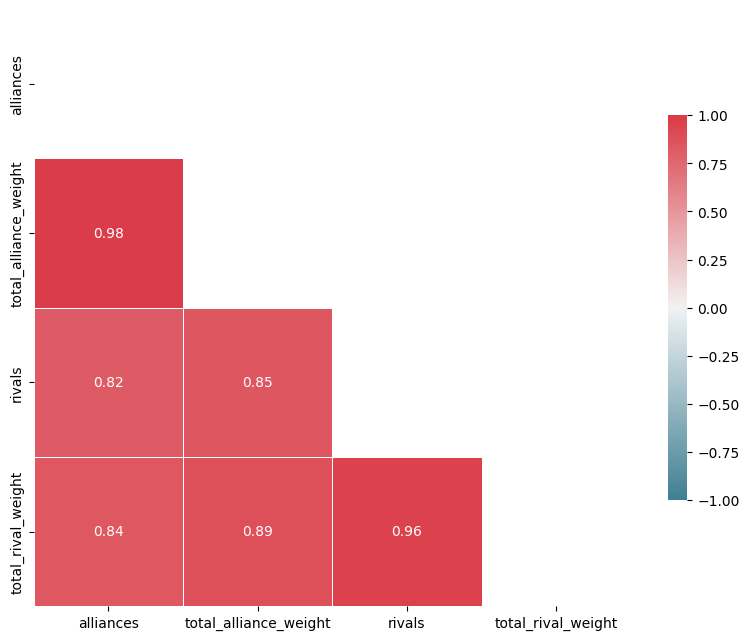

In [18]:
corr = relationship_count_df.drop(columns=['Group']).corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

- The extremely high positive correlation between alliances and total_alliances_weight indicates that cartels with more alliances also tend to hhave a presence in a greater number of states through these alliances. This suggests that the more alliances a cartel forms, the wider their influence or operational presence across different states.
- There is a strong positive correlation between the number of alliances and the number of rivals. This implies that cartels forming more alliances are also likely to have more rivals. It suggests a competitive environment where increased networking (alliances) also leads to more conflicts or competitive relationships (rivals).
- The strong positive correlation between alliances and total_rival_weight  indicates that cartels with more alliances tend to have rivals across more states. This could mean that as cartels grow their network of alliances, they attract or provoke rivalry from adversaries across a broader geographic area.
- A high positive correlation between the total number of states with alliances and the number of rivals suggests that cartels with a presence in more states (through alliances) tend to have more rivals. This might indicate that a wider geographic presence leads to increased competition and rivalry.
- The very high positive correlation between total_rival_weight and total_alliance_weight signifies that cartels with a presence in more states (through alliances) also face rivals in a greater number of states. It suggests a balance of power where influential cartels attract equally widespread rivalries, maintaining a kind of equilibrium in terms of geographic influence.
- The near-perfect positive correlation between rivals and total_rival_weight shows that cartels with more rivals face rivals in a greater number of states. This indicates that the sheer number of rivalries correlates very closely with the geographic spread of these rivalries.

# 🗒️ Summary

The data suggests a tightly interconnected network of cartels where the formation of alliances and rivalries are closely linked. Cartels that are more active in forming alliances tend to also face significant rivalries. This can be interpreted as an indication of the competitive and often antagonistic nature of cartel relationships, where building alliances to gain influence across states also simultaneously attracts competition and conflict with other powerful entities.

For law enforcement and policymakers, understanding these dynamics can help in predicting the behavior of cartels based on their network activities. Targeting influential alliances could potentially disrupt the balance and weaken both the alliances and the rivalries simultaneously.

# 🔚 The End
I hope you enjoyed this short network analysis notebook where I analysed relationships between cartels. If it was helpful, I would appreciate an upvote and a comment. ❤️